In [1]:
import sys, os, time, copy, gc
import torch
from torch import nn
from torch.utils.data import DataLoader
from pathlib import Path
import torchvision

import numpy as np
import pandas as pd

import warnings

sys.path.append('../src')
from train import *
from models import *
from dataset import *
from pre_processing import *

/home/sushruth/.local/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-11-09 10:45:52.164526: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-09 10:45:52.824303: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Configure the training run

In [2]:
 # Unet defined in models.py
CONFIG ={   
    "model" : 'UNet',
    "dataset" : 'COCO',
    "epochs": 60,
    "train_batch_size": 1000,
    "valid_batch_size": 1000,
    "learning_rate": 1e-3,
    "weight_decay": 1e-2,
    "scheduler": None,
    "model_params" : {
        "in_channels": 1,
        "out_channels": 2,
    },
    "scheduler_params" : {
        "T_max": 10,
        "min_lr": 1e-4
    },
    "device" : 'cuda',
    "loss" : 'MSE',
    "IN_COLORMAP" : 'GRAY_IMG',
    "OUT_COLORMAP" : 'lab',
    "display_loss_epoch" : 5,
    "IMG_RESIZE": 32,
    "validate_every_epoch": 5,
    "save_every_epoch": 5,
    "resume_training": True,
    "resume_checkpoint": "../models/tmp/UNet_2024-11-06_20_28_ep20.pth",
}

## Initializing the Device

In [3]:
if "device" not in CONFIG.keys():
    CONFIG["device"] = 'cpu' 
    print(f"Device was not specified in config. Using device: {CONFIG['device']}")
elif CONFIG["device"] == 'cuda' and torch.cuda.is_available():
    device = torch.device(CONFIG['device'])
    print(f"Using device: {device}")
elif torch.backends.mps.is_available() and CONFIG["device"] != "cpu":
    CONFIG["device"] = 'mps'
    device = torch.device("mps")
else:
    CONFIG["device"] = 'cpu' 
    print(f"Using device: {CONFIG['device']}")

Using device: cuda


## Preparing the Data

In [4]:
data_path = Path('../datasets')
coco_path = data_path/'coco'

In [5]:
if "dataset" not in CONFIG.keys() or CONFIG["dataset"] not in ['CIFAR10', 'COCO']:
    warnings.warn("Please specify a valid dataset in the config")

elif CONFIG["dataset"] == 'COCO':
    print("Using COCO dataset")
    coco_train_dataset = torchvision.datasets.CocoDetection(root=f"{coco_path}/train2017",annFile=f"{coco_path}/annotations/instances_train2017.json",transform=None,target_transform=None,transforms=None
)
    coco_val_dataset = torchvision.datasets.CocoDetection(root=f"{coco_path}/val2017",annFile=f"{coco_path}/annotations/instances_val2017.json",transform=None,target_transform=None,transforms=None
)
elif CONFIG["dataset"] == 'CIFAR10' :
    print("Using CIFAR10 dataset")
    cifar_train_dataset = torchvision.datasets.CIFAR10(data_path, train=True, transform=None)
    cifar_val_dataset = torchvision.datasets.CIFAR10(data_path, train=False, transform=None)

Using COCO dataset
loading annotations into memory...
Done (t=12.78s)
creating index...
index created!
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!


In [6]:
transform_in = getTransform_in(CONFIG)
transform_out = getTransform_out(CONFIG)


In [7]:
if CONFIG["dataset"] == 'CIFAR10':
    train_dataset = BuildImageDataset(cifar_train_dataset, transform_in=transform_in, transform_out=transform_out)
    valid_dataset = BuildImageDataset(cifar_val_dataset, transform_in=transform_in, transform_out=transform_out)
elif CONFIG["dataset"] == 'COCO':
    train_dataset = BuildImageDataset(coco_train_dataset, transform_in=transform_in, transform_out=transform_out)
    valid_dataset = BuildImageDataset(coco_val_dataset, transform_in=transform_in, transform_out=transform_out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4844142..0.45824316].


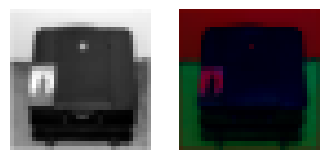

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4404271..0.4230771].


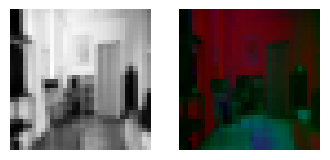

In [8]:
idx_train = np.random.randint(0, len(train_dataset))
idx_valid = np.random.randint(0, len(valid_dataset))
#Display random image from train dataset
train_dataset.display_img_pair(idx = idx_train,upscaling_factor=4)
#Display random image from train dataset
valid_dataset.display_img_pair(idx = idx_valid,upscaling_factor=4)

#Note:This target image may be different from the original image as the original image is converted to lab color space

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], shuffle=True,pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], shuffle=False,pin_memory=True)

In [10]:
model = setup_model(CONFIG)
display_trainable_params(model,img_size=(CONFIG['IMG_RESIZE'],CONFIG['IMG_RESIZE']))

Generating summary for model with input size 32x32
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
        DoubleConv-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]     

7701890

## Run the Training

In [11]:
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer, CONFIG)

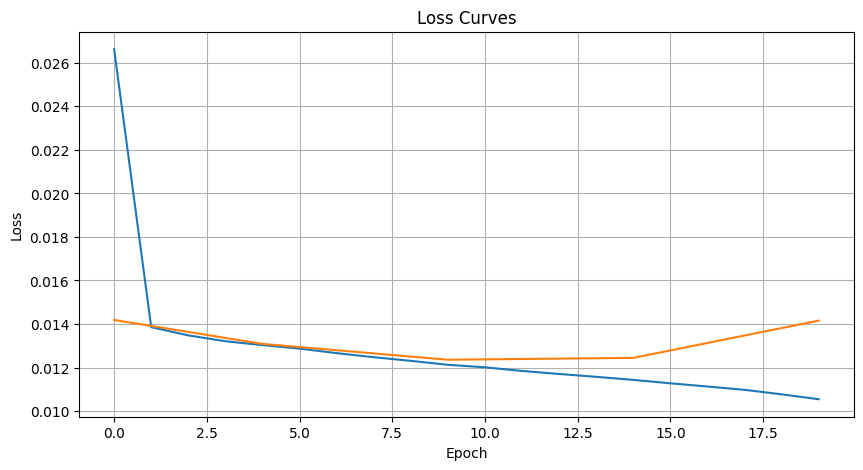

Attempting to resume training from epoch 20
Skipping epoch 1 until resuming epoch 21
Skipping epoch 2 until resuming epoch 21
Skipping epoch 3 until resuming epoch 21
Skipping epoch 4 until resuming epoch 21
Skipping epoch 5 until resuming epoch 21
Skipping epoch 6 until resuming epoch 21
Skipping epoch 7 until resuming epoch 21
Skipping epoch 8 until resuming epoch 21
Skipping epoch 9 until resuming epoch 21
Skipping epoch 10 until resuming epoch 21
Skipping epoch 11 until resuming epoch 21
Skipping epoch 12 until resuming epoch 21
Skipping epoch 13 until resuming epoch 21
Skipping epoch 14 until resuming epoch 21
Skipping epoch 15 until resuming epoch 21
Skipping epoch 16 until resuming epoch 21
Skipping epoch 17 until resuming epoch 21
Skipping epoch 18 until resuming epoch 21
Skipping epoch 19 until resuming epoch 21
Skipping epoch 20 until resuming epoch 21


Epoch 21/60:  78%|███████▊  | 93/119 [48:10<13:37, 31.43s/it] 

In [ ]:
model_out, train_loss,valid_loss, lr_rate = train_model(
    train_loader= train_dataloader,
    valid_loader= valid_dataloader,
    model= model,
    optimizer= optimizer,
    scheduler= scheduler,
    CONFIG= CONFIG)

## Save the model checkpoint

In [13]:
checkpoint = {
    'model': model_out,
    'state_dict': model_out.state_dict(),
    'optimizer': optimizer.state_dict(),
    #'scheduler': scheduler.state_dict(),
    'CONFIG': CONFIG,
    'train_loss': train_loss,
    'valid_loss': valid_loss,
    'lr_rate': lr_rate
}
#not using hash_config for now
def hash_config(config):
    import hashlib
    return hashlib.md5(str(config).encode()).hexdigest()
#get date and time
now = time.localtime()
if not os.path.exists(f'../models/{CONFIG["model"]}_{time.strftime("%Y-%m-%d_%H_%M", now)}.pth'):
    torch.save(checkpoint, f'../models/{CONFIG["model"]}_{time.strftime("%Y-%m-%d_%H_%M", now)}.pth')
    print("Model saved")
else:
    print("Model name already exists")
    print(f'../models/{CONFIG["model"]}_{time.strftime("%Y-%m-%d_%H_%M", now)}.pth')

Model saved
